Link to the original blog post: https://jina.ai/news/the-best-of-both-worlds-integrating-traditional-bm25-search-with-neural-reranking

### Upload files to Google Colab

Before we can access local files on Google Colab, we need to upload them to the Colab environment. Here are the steps to do so:
    
1. [Download the file `fashion_data.csv`](https://raw.githubusercontent.com/jina-ai/workshops/main/notebooks/embeddings/bm25/fashion_data.csv) to your local drive.
2. Click on the “Files” tab on the left-side menu in Google Colab (Make sure it is the “Files tab” not the “File” Dropdown menu).
3. Click on the “Upload to Session Storage” button and select the `fashion_data.csv` file you previously downloaded.
4. Wait for the upload to complete.

Once the `fashion_data.csv` file is uploaded, you can access it in the “Files” tab.

# The Best of Both Worlds: Integrating Traditional BM25 Search with Neural Reranking

Install prerequisites:

In [ ]:
!pip install --q haystack-ai jina-haystack

Add the Jina API key as environment variable:

In [ ]:
import os
import getpass

os.environ["JINA_API_KEY"] = getpass.getpass()

Define the query in form of the product category:

In [ ]:
query = "Nightwear for Women"

Transform the data into Documents:

In [ ]:
import csv
from haystack import Document

documents = []
with open("fashion_data.csv") as f:
    data = csv.reader(f, delimiter=";")
    for row in data:
      row_text = ''.join(row)
      row_doc = Document(content=row_text, meta={"prod_id": row[0], "prod_image": row[1]})
      documents.append(row_doc)

Create the query pipeline WITHOUT Jina Reranker to compare the results prior to the reranking:

In [ ]:
from haystack import Pipeline
from haystack.document_stores.types import DuplicatePolicy
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.retrievers.in_memory import InMemoryBM25Retriever

document_store=InMemoryDocumentStore()
document_store.write_documents(documents=documents, policy=DuplicatePolicy.OVERWRITE)

retriever = InMemoryBM25Retriever(document_store=document_store)

rag_pipeline = Pipeline()
rag_pipeline.add_component("retriever", retriever)

Run the query pipeline WITHOUT Jina Reranker:

In [ ]:
result = rag_pipeline.run(
            {
                "retriever": {"query": query, "top_k": 15},
            }
        )

for doc in result["retriever"]["documents"]:
    print("Product ID:", doc.meta["prod_id"])
    print("Product Image:", doc.meta["prod_image"])
    print("Score:", doc.score)
    print("-"*100)

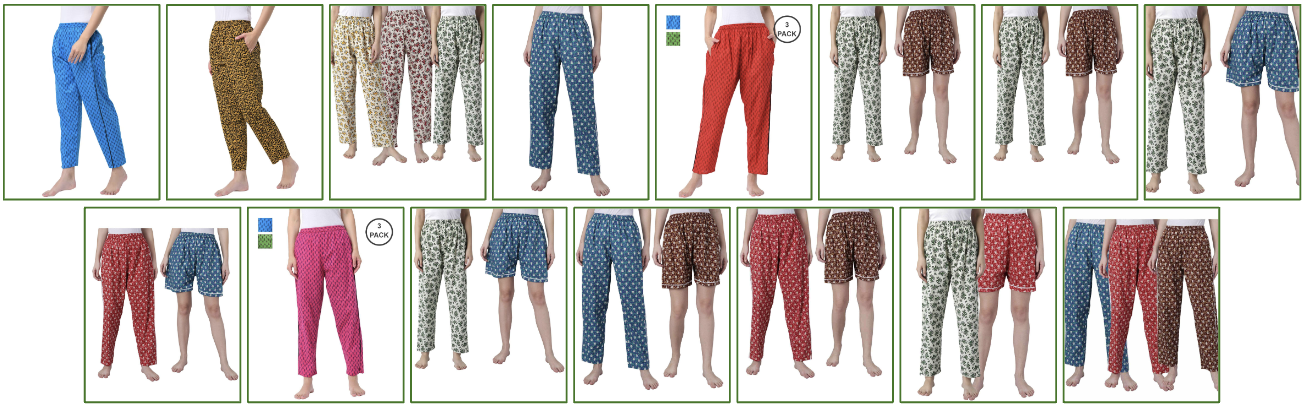

*As we can see, BM25 correctly matches all products but only suggests different variants of the same product, i.e. pajamas trousers. Although very related to what were are searching, the results seem quite shallow and limited.*

Create the query pipeline WITH Jina Reranker to compare the results after the reranking:

In [ ]:
from haystack_integrations.components.rankers.jina import JinaRanker

ranker_retriever = InMemoryBM25Retriever(document_store=document_store)

ranker = JinaRanker()

ranker_pipeline = Pipeline()
ranker_pipeline.add_component("ranker_retriever", ranker_retriever)
ranker_pipeline.add_component("ranker", ranker)

ranker_pipeline.connect("ranker_retriever.documents", "ranker.documents")

Run the query pipeline WITH Jina Reranker:

In [ ]:
result = ranker_pipeline.run(
            {
                "ranker_retriever": {"query": query, "top_k": 100},
                "ranker": {"query": query, "top_k": 15},
            }
        )

for doc in result["ranker"]["documents"]:
    print("Product ID:", doc.meta["prod_id"])
    print("Product Image:", doc.meta["prod_image"])
    print("Score:", doc.score)
    print("-"*100)

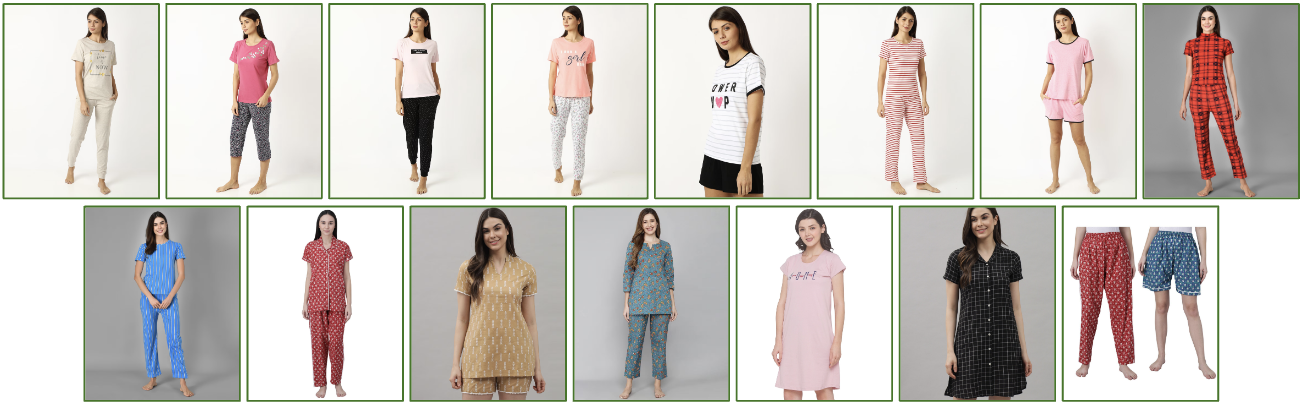

*Compared to BM25, Jina Reranker suggests a much more varied collection of nightwear sets and pajamas, showing a clear improvement compared to the previous BM25 results. This difference translates into a much better user experience and increased likelihood of purchases based on accurate product retrieval.*